# Setup before training

Directory structure:
* project/
* project/data/
* project/data/raw             #original videos
* project/data/source        
* project/data/source/full     #data videos matching the slice folder, converted to grey and resized to 50x50
* project/data/source/slice    #data prepared for training in subfolders, containing frames instead of videos
* project/data/wrk             #here we have a config file containing current run
* project/data/wrk/prorun<nn>  #a folder for each new training run
    
Functions:
* prorun_setup()              #create a new wrk/prorun<nn> folder and change current run (project.conf) setup training,validate and test dataset (createing list)
* prorun_clear()              #clear logs,datasetlist of current prorun
* prorun_start()              #start training model
* prorun_stop()               #stopo training model
* prorun_show()               #show status of model

In [3]:
#import modules
import os
import configparser
import random
import math
import numpy as np
import keras
from keras.preprocessing import image
import matplotlib.pyplot as plt
import logging
from datetime import datetime
import sys

#from keras.models import Sequential
#from keras.layers.normalization import BatchNormalization
#from keras.layers.convolutional import Conv2D
#from keras.layers.convolutional import MaxPooling2D
#from keras.layers.core import Activation
#from keras.layers.core import Dropout
#from keras.layers.core import Dense
#from keras.layers import Flatten
#from keras.layers import Input
#from keras.models import Model

import innvestigate
import innvestigate.utils as iutils

%matplotlib inline 

sys.setrecursionlimit(10000)

from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

#configurations
projectFolder = "F:/ud_MLEN/UU/CAIA_II/Project"
wrkFolder = projectFolder + "/wrk"
dataFolder = projectFolder + "/data/source100/slice"
projectConfig = wrkFolder + "/project.conf"

#Constants
DATASET_SIZE = 100
TRAININGDATA_SIZE = 70
TEST_VALIDATION_SPLIT = 50
MODEL = 1
EPOCHS = 20
BATCH_SIZE = 100
ENGINE_BATCH_SIZE = 200
ENGINE_MAX_ITER = 50
VERBOSE = 1
SPLIT_MODE = 2
FRAME_SIZE=100

#useful functions
def logg_write(message):
    now = datetime.now()
    current_time = now.strftime("%Y-%m-%d %H:%M:%S")
    with open(logFile, 'a') as f: 
        f.write(current_time + " " + message + "\n") 
        
def setup_logging(logFile):
    #logging.basicConfig(filename=logFile, format='%(asctime)s %(levelname)s: %(message)s', level=logging.DEBUG)
    pass
    
def logg_info(message):
    #logging.info(message)
    logg_write("INFO: " + message)
    
def logg_warning(message):
    #logging.warning(message)
    logg_write("WARNING: " + message)
    
def logg_debug(message):
    #logging.debug(message)
    logg_write("DEBUG: " + message)
    
def logg_error(message):
    #logging.error(message)
    logg_write("ERROR: " + message)
        
def current_folder():
    return os.getcwd()
    
def change_current_folder(newFolder):
    os.chdir(newFolder)
    
def folder_content(folder):
    return [f for f in os.listdir(folder) if os.path.isfile(os.path.join(folder, f))]

def folders_in_folder(folder):
    return [f for f in os.listdir(folder) if os.path.isdir(os.path.join(folder, f))]

def folder_exists(folder):
    return os.path.exists(folder)

def file_exists(file):
    return os.path.isfile(file)

def create_folder(folder):
    if not os.path.exists(folder):
        os.makedirs(folder)
        
def remove_file(file):
    if file_exists(file):
        os.remove(file)
        
def write_list_to_file(dataList, file):
    with open(file, 'w') as filehandle:
        for listitem in dataList:
            filehandle.write('%s\n' % listitem)
            
def read_file_to_list(file):
    dataList = []
    with open(file, 'r') as filehandle:
        for line in filehandle:
            # remove linebreak which is the last character of the string
            currentItem = line[:-1]
            # add item to the list
            dataList.append(currentItem)
    return dataList

def list_subtraction(list1, list2):
    # list1 - list2, remove all elements in list2 from list1
    return [x for x in list1 if x not in list2]

def read_config_value(file,section,key):
    configValue = None
    if file_exists(file):
        config = configparser.ConfigParser()
        config.read(file)
        configValue = config[section][key]
    return configValue
    
def write_config_value(file, section, key, value):
    result = False
    try:
        config = configparser.ConfigParser()
        #load config file
        if file_exists(file):
            config.read(file)
        #create section if needed
        if not section in config.sections():
            config[section] = {}
        #add value to key
        config[section][key] = value
        #save config file
        with open(file, 'w') as configfile:
            config.write(configfile)
            result = True
    except:
        print('config write error: failed to write to ', file)
    else:
        return result
    
def show_status():
    print("Current folder:", current_folder())
    print("Project folder:", projectFolder)
    print("Data folder:", dataFolder)
    print("Work folder:", wrkFolder)
    currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
    section = 'PRORUN#' + currentNr
    prorunFolder = read_config_value(projectConfig,section,'folder')
    trainingFile = read_config_value(projectConfig,section,'trainingfile')
    trainingDataset = read_file_to_list(trainingFile)
    remainingFile = read_config_value(projectConfig,section,'remainingfile')
    remainingDataset = read_file_to_list(remainingFile)
    logFile = read_config_value(projectConfig,section,'logfile')
    modelFile = read_config_value(projectConfig,section,'modelfile')
    print("PRORUN:", currentNr)
    print("folder", prorunFolder)
    print("Trainingfile:", trainingFile)
    print("Size trainingdata:", len(trainingDataset))
    print("Remainingfile:", remainingFile)
    print("Size remainingdata:", len(remainingDataset))
    print("Logfile:", logFile)
    print("Model:", modelFile)

Using TensorFlow backend.


In [4]:
def unique(notUniqueList):
    listSet = set(notUniqueList)
    unique_list = (list(listSet))
    return unique_list

def expand_subset(dataset):
    dataList = folders_in_folder(dataFolder)
    result = []
    for i in dataset:
        for j in range(6):
            n = i + "_" + str(j+1)
            if n in dataList:
                result.append(n)
    return result       

def extract_subset(dataset, extractionSize):
    if (extractionSize >= 0 and extractionSize <= 100):
        dataPoints = int(math.ceil(len(dataset) * (extractionSize / 100)))
        result = np.random.choice(dataset, dataPoints, replace=False)
    else:
        #out of bounds
        print("extractionSize is out of bounds [0-100]", extractionSize)
    return result

def generate_dataset(mode, datasetSize):
    if mode == 1:
        dataList = folders_in_folder(dataFolder)
    if mode == 2:
        tmpList = []
        folderInFolder = folders_in_folder(dataFolder)
        for i in folderInFolder:
            tmpList.append(i[:7])
        dataList = unique(tmpList)
    return extract_subset(dataList, datasetSize)

def prorun_setup(mode, datasetSize, trainingSize, validationSize):
    #datasetSize, trainingSize, validationSize, testSize are all procentage e.g 70 means 70%
    #datasetSize is the total dataset in procentage of available datafiles
    if not file_exists(projectConfig):
        nn = '1'
    else:
        nn = read_config_value(projectConfig,'PRORUN','currentNr')
        if nn == None:
            nn = '1'
        else:
            nn = str(int(nn) + 1)
    prorunFolder = wrkFolder + '/prorun' + nn 
    section = 'PRORUN#' + nn
    create_folder(prorunFolder)

    #create datasetfiles
    trainingFile = prorunFolder + "/trainingFile"
    validationFile = prorunFolder + "/validationFile"
    testFile = prorunFolder + "/testFile"
    remainingFile = prorunFolder + "/remainingFile"
    logFile = prorunFolder + "/logFile"
    modelFile = prorunFolder + "/model.h5"
    
    totalDataset = generate_dataset(mode, datasetSize)
    trainingDataset = extract_subset(totalDataset, trainingSize)
    remainingDataset = list_subtraction(totalDataset, trainingDataset)
    validationDataset = extract_subset(remainingDataset, validationSize)
    testDataset = list_subtraction(remainingDataset, validationDataset)
    
    if mode == 2:
        trainingDataset = expand_subset(trainingDataset)
        remainingDataset = expand_subset(remainingDataset)
        validationDataset = expand_subset(validationDataset)
        testDataset = expand_subset(testDataset)
    
    write_list_to_file(trainingDataset,trainingFile)
    write_list_to_file(validationDataset,validationFile)
    write_list_to_file(testDataset,testFile)
    write_list_to_file(trainingDataset,remainingFile)
    
    #update project configfile
    write_config_value(projectConfig,'PRORUN','currentNr',nn)
    write_config_value(projectConfig,section,'folder',prorunFolder)
    write_config_value(projectConfig,section,'datasetSize',str(len(totalDataset)))
    write_config_value(projectConfig,section,'trainingSize',str(len(trainingDataset)))
    write_config_value(projectConfig,section,'validationSize',str(len(validationDataset)))
    write_config_value(projectConfig,section,'remainingSize',str(len(trainingDataset)))
    write_config_value(projectConfig,section,'testSize',str(len(testDataset)))
    write_config_value(projectConfig,section,'trainingFile',trainingFile)
    write_config_value(projectConfig,section,'validationFile',validationFile)
    write_config_value(projectConfig,section,'testFile',testFile)
    write_config_value(projectConfig,section,'remainingFile',remainingFile)
    write_config_value(projectConfig,section,'logFile',logFile)
    write_config_value(projectConfig,section,'modelFile',modelFile)
    write_config_value(projectConfig,section,'datasetSizeProcent',str(DATASET_SIZE))
    write_config_value(projectConfig,section,'trainingSizeProcent',str(TRAININGDATA_SIZE))
    write_config_value(projectConfig,section,'testValidationSplitProcent',str(TEST_VALIDATION_SPLIT))
    write_config_value(projectConfig,section,'model',str(MODEL))
    write_config_value(projectConfig,section,'epochs',str(EPOCHS))
    write_config_value(projectConfig,section,'batchSize',str(BATCH_SIZE))
    write_config_value(projectConfig,section,'engineBatchSize',str(ENGINE_BATCH_SIZE))
    write_config_value(projectConfig,section,'engineMaxIter',str(ENGINE_MAX_ITER))
    write_config_value(projectConfig,section,'splitMode',str(SPLIT_MODE))
    write_config_value(projectConfig,section,'frameSize',str(FRAME_SIZE))
    
    

In [5]:
l = generate_dataset(2, 10)
print(l)
l1 = expand_subset(l)
print(l1)

['vcH1088' 'vcP1293' 'vcP1275' 'vcR1310' 'vcP1263' 'vcF1036' 'vcW1535'
 'vcT1503' 'vcF1019' 'vcH1146' 'vcF1053' 'vcR1338' 'vcW1574' 'vcP1306'
 'vcJ1201' 'vcS1437' 'vcS1446' 'vcR1358' 'vcH1094' 'vcS1444' 'vcW1534'
 'vcH1072' 'vcJ1219' 'vcR1430' 'vcH1098' 'vcF1032' 'vcT1481' 'vcJ1225'
 'vcT1517' 'vcP1278' 'vcT1490' 'vcP1283' 'vcH1071' 'vcH1090' 'vcP1303'
 'vcJ1174' 'vcJ1218' 'vcJ1217' 'vcJ1198' 'vcH1114' 'vcT1514' 'vcH1137'
 'vcR1315' 'vcR1422' 'vcW1519' 'vcP1273' 'vcW1523' 'vcJ1205' 'vcJ1229'
 'vcJ1244' 'vcR1363' 'vcR1392' 'vcT1463' 'vcP1250' 'vcH1095' 'vcS1445'
 'vcT1477' 'vcW1537' 'vcR1386']
['vcH1088_1', 'vcH1088_2', 'vcH1088_3', 'vcH1088_4', 'vcH1088_5', 'vcP1293_1', 'vcP1293_2', 'vcP1293_3', 'vcP1293_4', 'vcP1293_5', 'vcP1275_1', 'vcP1275_2', 'vcP1275_3', 'vcP1275_4', 'vcP1275_5', 'vcP1275_6', 'vcR1310_1', 'vcR1310_2', 'vcR1310_3', 'vcP1263_1', 'vcP1263_2', 'vcP1263_3', 'vcF1036_1', 'vcF1036_2', 'vcF1036_3', 'vcF1036_4', 'vcW1535_1', 'vcW1535_2', 'vcW1535_3', 'vcW1535_4', 'vcT1503_

In [6]:
def save_model(model, modelFile):
    model.save(modelFile)
    
def load_model(modelFile):
    model = None
    if file_exists(modelFile):
        model = keras.models.load_model(modelFile)
    return model

def remove_model(model):
    del model

def load_datapoint(dataPointRef):
    content = folder_content(dataFolder + "/" + dataPointRef)
    first = True
    for i in content:
        img = image.load_img(dataFolder + "/" + dataPointRef + "/" + i)
        data = np.asarray(img)[:,:,0]
        if first:
            tensorData = [data]
            first = False
        else:
            tensorData.append(data)
    #tensor = np.stack(tensorData, axis=0)
    tensor = np.stack(tensorData, axis=2)
    return tensor

def get_target(dataPointRef):
    return dataPointRef[2:3]

def compare_code(a,b):
    if a == b:
        return 1
    else:
        return 0
    
def target_encoding(target):
    codeList = ['F','H','J','P','R','S','T','W']
    return np.asarray([compare_code(target,i) for i in codeList])

def create_dataset(DataPointsList):
    tensorList = []
    targetList = []
    for dataPoint in DataPointsList:
        tensorList.append(load_datapoint(dataPoint))
        targetList.append(target_encoding(get_target(dataPoint)))
    return np.stack(tensorList, axis=0), np.stack(targetList, axis=0)

#def create_preprocessing_fn(X):
    #input_range=[-1, 1]
    #a, b = X.min(), X.max()
    #a, b = [0.0, 255.0]
    #c, d = [-1, 1]
    
        #X = X - a     ### X = X - 0.0
        # scale to new range gap [0, d-c]
        #X /= (b-a)    ### 255.0 - 0.0 => X/= 255.0
        #X *= (d-c)    ### X *= 2
        # shift to desired output range
        #X += c        ### X+= -1
        
        #X = X - c     ### X = X - (-1) = X + 1
        #X /= (d-c)    ### X /= 2
        #X *= (b-a)    ### X *= 255.0
        #X += a        ### X += 0.0
        
    def preprocessing(X):
        # shift original data to [0, b-a] (and copy)
        #X = X - a
        # scale to new range gap [0, d-c]
        #X /= (b-a)
        #X *= (d-c)
        # shift to desired output range
        #X += c
        X /= 127.5       
        X+= -1
        return X

    def revert_preprocessing(X):
        #X = X - c
        #X /= (d-c)
        #X *= (b-a)
        #X += a
        X = X + 1
        X *= 127.5
        return X

    return preprocessing, revert_preprocessing

def fn_preprocessing(X):
    X /= 127.5       
    X+= -1
    return X
    
def fn_revert_preprocessing(X):
    X = X + 1
    X *= 127.5
    return X
    
def preprocess_functions(inputData):
    #(x,_) = create_dataset(inputData)
    #xData = x.astype("float32")
    #preprocess, revert_preprocessing = create_preprocessing_fn(xData)
    return (fn_preprocessing, fn_revert_preprocessing)

def preprocess(inputData, targetData, preprocFn):    
    xData = preprocFn(inputData.astype("float32")) 
    yData = targetData
    return xData, yData

def create_model(modelNr):
    model = None
    #input_shape = (16, FRAME_SIZE, FRAME_SIZE)
    input_shape = (FRAME_SIZE, FRAME_SIZE, 16)
    if modelNr == 1:
        model = keras.models.Sequential([
            keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=input_shape),
            keras.layers.Conv2D(64, (3, 3), activation="relu"),
            keras.layers.MaxPooling2D((2, 2)),
            keras.layers.Flatten(),
            keras.layers.Dense(512, activation="relu"),
            keras.layers.Dense(8, activation="softmax"),
            ])
    if modelNr == 2:
        inputA = keras.layers.Input(shape=(4, FRAME_SIZE, FRAME_SIZE))
        inputB = keras.layers.Input(shape=(4, FRAME_SIZE, FRAME_SIZE))
        inputC = keras.layers.Input(shape=(4, FRAME_SIZE, FRAME_SIZE))
        inputD = keras.layers.Input(shape=(4, FRAME_SIZE, FRAME_SIZE))
        
        a = keras.layers.Conv2D(32, (3, 3), activation="relu") (inputA)
        a = keras.layers.BatchNormalization(axis=2) (a)
        a = keras.layers.MaxPooling2D((2, 2)) (a)
                
        b = keras.layers.Conv2D(32, (3, 3), activation="relu") (inputB)
        b = keras.layers.BatchNormalization(axis=2) (b)
        b = keras.layers.MaxPooling2D((2, 2)) (b)
                
        c = keras.layers.Conv2D(32, (3, 3), activation="relu") (inputC)
        c = keras.layers.BatchNormalization(axis=2) (c)
        c = keras.layers.MaxPooling2D((2, 2)) (c)
                
        d = keras.layers.Conv2D(32, (3, 3), activation="relu") (inputD)
        d = keras.layers.BatchNormalization(axis=2) (d)
        d = keras.layers.MaxPooling2D((2, 2)) (d)
                
        ab = keras.layers.concatenate( [a, b], axis=2)
        cd = keras.layers.concatenate( [c, d], axis=2)
        
        ab = keras.layers.Conv2D(20, (3, 3), activation="relu") (ab)
        ab = keras.layers.BatchNormalization(axis=2) (ab)
        ab = keras.layers.MaxPooling2D((2, 2)) (ab)
        
        cd = keras.layers.Conv2D(20, (3, 3), activation="relu") (cd)
        cd = keras.layers.BatchNormalization(axis=2) (cd)
        cd = keras.layers.MaxPooling2D((2, 2)) (cd)
        
        abcd = keras.layers.concatenate([ab, cd], axis=2)
        
        abcd = keras.layers.Conv2D(16, (3, 3), activation="relu") (abcd)
        abcd = keras.layers.Conv2D(64, (3, 3), activation="relu") (abcd)
        abcd = keras.layers.MaxPooling2D((2, 2)) (abcd)
        abcd = keras.layers.Dense(512, activation="relu") (abcd)
        abcd = keras.layers.Dense(8, activation="softmax") (abcd)
        model = keras.models.Model(inputs=[inputA, inputB, inputC, inputD], outputs=abcd)
        
    return model

def multiple_input_split(modelNr, x):
    if modelNr == 1:
        mix = [x]
    if modelNr == 2:
        mix = [x[0:3,:,:], x[4:7,:,:], x[8:11,:,:], x[12:15,:,:]]
    return mix

def train_model(dataPointList, model, preprocFn):
    
    (x,y) = create_dataset(dataPointList)
    (x1, y1) = preprocess(x, y, preprocFn)
    
    if model == None: #create model        
        model = create_model(MODEL)
        
    multi_input = multiple_input_split(MODEL, x1)
    
    #train model
    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.fit(multi_input, y1, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose = VERBOSE)
    return model
    
def evaluate_model(dataPointList, model, preprocFn):
    (x,y) = create_dataset(dataPointList)
    (x1,y1) = preprocess(x,y,preprocFn)
    scores = model.evaluate(x1, y1, batch_size=BATCH_SIZE)
    logg_info(f"Scores on dataset: loss={scores[0]} accuracy={scores[1]}")
    print(f"Scores on dataset: loss={scores[0]} accuracy={scores[1]}")

In [7]:
q1 = [[1, 1, 1],[1, 1, 1],[1, 1, 1],[1, 1, 1]]
q2 = [[2, 2, 2],[2, 2, 2],[2, 2, 2],[2, 2, 2]]
q3 = [[3, 3, 3],[3, 3, 3],[3, 3, 3],[3, 3, 3]]
q4 = [[4, 4, 4],[4, 4, 4],[4, 4, 4],[4, 4, 4]]
qv = np.asarray([q1, q1, q1, q1, q2, q2, q2, q2, q3, q3, q3, q3, q4, q4, q4, q4])
mix = multiple_input_split(2, qv)

#print(qv)
#print(mix[2])



In [8]:
def start_engine():
    currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
    section = 'PRORUN#' + currentNr
    runFile = wrkFolder + "/run." + currentNr
    stopFile = wrkFolder + "/stop." + currentNr
    remove_file(stopFile)
    write_list_to_file(['run'],runFile)
    
def stop_engine():
    currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
    section = 'PRORUN#' + currentNr
    runFile = wrkFolder + "/run." + currentNr
    stopFile = wrkFolder + "/stop." + currentNr    
    write_list_to_file(['stop'],stopFile)
    
def reset_training():
    currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
    section = 'PRORUN#' + currentNr
    runFile = wrkFolder + "/run." + currentNr
    stopFile = wrkFolder + "/stop." + currentNr   
    stop_engine()
    if file_exists(runFile):
        print("engine is still running")
    else:
        #copy trainingfile to remainingfile
        trainingFile = read_config_value(projectConfig,section,'trainingfile')
        trainingDataset = read_file_to_list(trainingFile)
        remainingFile = read_config_value(projectConfig,section,'remainingfile')
        write_list_to_file(trainingDataset,remainingFile)
        #remove model
        modelFile = read_config_value(projectConfig,section,'modelfile')
        if file_exists(modelFile):
            remove_file(modelFile)
    
def engine_run():
    
    batchSize = ENGINE_BATCH_SIZE
    maxIter = ENGINE_MAX_ITER
    counter = 0
    run = True
    currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
    section = 'PRORUN#' + currentNr
    remainingFile = read_config_value(projectConfig,section,'remainingfile')
    validationFile = read_config_value(projectConfig,section,'validationfile')
    trainingFile = read_config_value(projectConfig,section,'trainingfile') 
    modelFile = read_config_value(projectConfig,section,'modelfile') 
    evalDataPointList = read_file_to_list(validationFile)
    
    runFile = wrkFolder + "/run." + currentNr
    stopFile = wrkFolder + "/stop." + currentNr
    logFile = read_config_value(projectConfig,section,'logfile')  
    setup_logging(logFile)
    logg_info("Starts Engine")
    (pp, rpp) = preprocess_functions(read_file_to_list(trainingFile))
    
    model = load_model(modelFile)
    while (run):    
        counter = counter + 1
        logg_info("Start Engine Batch: " + str(counter))
        remainingDataset = read_file_to_list(remainingFile)           
        if file_exists(stopFile):
            remove_file(runFile)            
        if (file_exists(runFile)) and (counter < maxIter) and (remainingDataset != []):
            #Execute next round    
            #print("Counter: ", counter, len(remainingDataset))
            if (len(remainingDataset) > batchSize):
                batch = np.random.choice(remainingDataset, batchSize, replace=False)
                remainingDataset = list_subtraction(remainingDataset, batch)
                #TRAIN MODEL HERE!
                print("Counter: ", counter, len(remainingDataset))
                model = train_model(batch, model, pp)
                evaluate_model(evalDataPointList, model, pp)
                #print("Counter: ", counter, len(remainingDataset),batch)
                write_list_to_file(remainingDataset,remainingFile)   
                save_model(model,modelFile)  
            else:
                run = False
        else:
            run = False
            
    #evaluate model
    del model
    model = load_model(modelFile)
    logg_info("Final Evaluation")
    evaluate_model(evalDataPointList, model, pp)
    logg_info("Stops Engine")

            

# Exekvering

In [9]:
print(SPLIT_MODE,DATASET_SIZE,TRAININGDATA_SIZE,TEST_VALIDATION_SPLIT)
prorun_setup(SPLIT_MODE,DATASET_SIZE,TRAININGDATA_SIZE,TEST_VALIDATION_SPLIT)
show_status()

2 100 70 50
Current folder: F:\ud_MLEN\UU\CAIA_II\Project\innvestigate-master\examples\notebooks
Project folder: F:/ud_MLEN/UU/CAIA_II/Project
Data folder: F:/ud_MLEN/UU/CAIA_II/Project/data/source100/slice
Work folder: F:/ud_MLEN/UU/CAIA_II/Project/wrk
PRORUN: 10
folder F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10
Trainingfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/trainingFile
Size trainingdata: 1687
Remainingfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/remainingFile
Size remainingdata: 1687
Logfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/logFile
Model: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/model.h5


In [10]:
currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
section = 'PRORUN#' + currentNr
logFile = read_config_value(projectConfig,section,'logfile') 
show_status()
start_engine()
engine_run()

Current folder: F:\ud_MLEN\UU\CAIA_II\Project\innvestigate-master\examples\notebooks
Project folder: F:/ud_MLEN/UU/CAIA_II/Project
Data folder: F:/ud_MLEN/UU/CAIA_II/Project/data/source100/slice
Work folder: F:/ud_MLEN/UU/CAIA_II/Project/wrk
PRORUN: 10
folder F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10
Trainingfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/trainingFile
Size trainingdata: 1687
Remainingfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/remainingFile
Size remainingdata: 1687
Logfile: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/logFile
Model: F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun10/model.h5
Counter:  1 1487






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Epoch 1/20





200/200 [==============================] - 10s 50ms/step - loss: 6.5495 - acc: 0.1650
Epoch 2/20
200/200 [==============================] - 9s 44ms/step - loss: 13.6976 - acc: 0.1500
Epoch 3/20
200/200 [==============================] - 10s 50ms/step 

200/200 [==============================] - 11s 57ms/step - loss: 0.1928 - acc: 0.9650
Epoch 3/20
200/200 [==============================] - 11s 56ms/step - loss: 0.1638 - acc: 0.9500
Epoch 4/20
200/200 [==============================] - 10s 49ms/step - loss: 0.0723 - acc: 0.9850
Epoch 5/20
200/200 [==============================] - 10s 52ms/step - loss: 0.0820 - acc: 0.9750
Epoch 6/20
200/200 [==============================] - 11s 53ms/step - loss: 0.0647 - acc: 0.9850
Epoch 7/20
200/200 [==============================] - 8s 40ms/step - loss: 0.0544 - acc: 0.9850
Epoch 8/20
200/200 [==============================] - 9s 44ms/step - loss: 0.0379 - acc: 0.9900
Epoch 9/20
200/200 [==============================] - 8s 40ms/step - loss: 0.1115 - acc: 0.9750
Epoch 10/20
200/200 [==============================] - 9s 44ms/step - loss: 0.0256 - acc: 0.9950
Epoch 11/20
200/200 [==============================] - 9s 43ms/step - loss: 0.0256 - acc: 0.9850
Epoch 12/20
200/200 [=======================

In [ ]:
stop_engine()

In [ ]:
reset_training()

In [ ]:
print(dataFolder)

In [ ]:
show_status()

# Load and use a trained model

In [11]:
def get_img_from_tensor(tensor, slice):
    tensorList = [tensor[:,:,slice], tensor[:,:,slice], tensor[:,:,slice]]
    img = np.stack(tensorList, axis=2)
    return img

def show_tensor(tensor):
    plt.subplots(4,4,figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4,i+1)
        plt.imshow(get_img_from_tensor(tensor, i))
    plt.show()
    
def show_hotspot(tensor, relevance):
    plt.subplots(4,4,figsize=(15,15))
    for i in range(16):
        plt.subplot(4,4,i+1)
        t = get_img_from_tensor(tensor, i)
        r = get_img_from_tensor(relevance,i)
        r = r.sum(axis=np.argmax(np.asarray(r.shape) == 3))
        r /= np.max(np.abs(r))
        r = [r > 0.3]
        t[:,:,0][r] = 255
        plt.imshow(t)
    plt.show()
    
def prep_model(model):
    model_wo_sm = iutils.keras.graph.model_wo_softmax(model)
    return model_wo_sm
        

In [12]:
currentNr = read_config_value(projectConfig,'PRORUN','currentnr')
section = 'PRORUN#' + currentNr
modelFile = read_config_value(projectConfig,section,'modelFile') 

#model = load_model("F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun9/model.h5")
model = load_model(modelFile)
model.summary()
model_wo_sm = prep_model(model)
model_wo_sm.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 98, 98, 32)        4640      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 147456)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               75497984  
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
Total params: 75,525,224
Trainable params: 75,525,224
Non-trainable params: 0
________________________________________________________________

In [13]:
testFile = read_config_value(projectConfig,section,'testFile') 
testDataset = read_file_to_list(testFile)
(pp, rpp) = preprocess_functions(testDataset)


#(datasetX,datasetY) = create_dataset(['vcP1270_3'])
#(datasetX,datasetY) = create_dataset(['vcP1271_3'])
(datasetX, datasetY) = create_dataset(testDataset)
(prepDatasetX,prepDatasetY) = preprocess(datasetX,datasetY,pp)

#print(datasetX.shape)
#myImage = datasetX.reshape(FRAME_SIZE,FRAME_SIZE,16)
#print(datasetX.shape)
#plt.imshow(myImage[:,:,0], cmap='gray', interpolation='nearest')
#plt.show()
p = model.predict(prepDatasetX, verbose=1)
print(p)

363/363 [==============================] - 6s 18ms/step
[[3.45688408e-12 4.09097720e-06 1.11158115e-04 ... 3.54198449e-18
  1.53939109e-04 1.89321451e-02]
 [5.39906704e-12 9.16487508e-08 1.15669091e-05 ... 3.76194091e-18
  6.14864286e-04 2.92384356e-01]
 [1.01681927e-11 1.05075074e-07 6.23322194e-06 ... 3.16708266e-18
  3.60373815e-05 3.54511470e-01]
 ...
 [2.00302928e-29 1.00000000e+00 2.60710850e-20 ... 0.00000000e+00
  1.63675939e-29 1.37394157e-16]
 [1.11644657e-27 1.00000000e+00 3.48175668e-20 ... 1.35740217e-37
  8.80772000e-30 6.70879264e-16]
 [8.42220239e-29 1.00000000e+00 8.33788338e-19 ... 5.10364503e-38
  1.18241246e-30 1.96976281e-16]]


In [ ]:
print([p[1]>0.01])

In [14]:
def decode(pred):
    codeList = ['F','H','J','P','R','S','T','W']
    result = None
    p_score = 0
    for i in range(len(codeList)):
        if pred[i] > p_score:
            result = codeList[i]
            p_score = pred[i]
    return (result, p_score)

def get_categories():
    return {'F':1,'H':2,'J':3,'P':4,'R':5,'S':6,'T':7,'W':8}

def catNr(cat):
    return get_categories().get(cat)

def catCode(catNr):
    result = None
    dict_cat = get_categories()
    keys = dict_cat.keys()
    for k,v in dict_cat.items():
        if v == catNr:
            result = k
    return result


In [20]:

calcTotal = len(testDataset)
calcCorrect = 0
calcWrong = 0
for i in range(len(testDataset)):
    cat, p_score = decode(p[i])
    catFacit = testDataset[i][2:3]
    print(i,testDataset[i],catFacit,cat,p_score)
    if cat == catFacit:
        calcCorrect = calcCorrect + 1
    else:
        calcWrong = calcWrong + 1
print(calcCorrect, calcWrong, calcTotal, calcCorrect/calcTotal)
    

0 vcS1455_1 S R 0.98079866
1 vcS1455_2 S R 0.7069891
2 vcS1455_3 S R 0.64544624
3 vcS1455_4 S R 0.8556495
4 vcP1256_1 P P 0.99990094
5 vcP1256_2 P P 0.9994887
6 vcP1256_3 P P 0.99998474
7 vcP1256_4 P P 0.9999341
8 vcP1256_5 P P 0.999985
9 vcJ1229_1 J J 0.86929077
10 vcJ1229_2 J J 0.7109086
11 vcJ1229_3 J T 0.91239333
12 vcJ1242_1 J W 0.9997842
13 vcJ1242_2 J W 0.999864
14 vcJ1242_3 J W 0.9996032
15 vcJ1242_4 J W 0.9999944
16 vcJ1242_5 J W 0.99984443
17 vcW1548_1 W W 1.0
18 vcW1548_2 W W 1.0
19 vcW1548_3 W W 1.0
20 vcW1548_4 W W 1.0
21 vcW1548_5 W W 1.0
22 vcR1323_1 R R 0.85924494
23 vcR1323_2 R R 0.9010465
24 vcR1323_3 R R 0.5739567
25 vcR1324_1 R W 0.39232498
26 vcR1324_2 R W 0.5626492
27 vcR1324_3 R W 0.6204214
28 vcH1069_1 H H 1.0
29 vcH1069_2 H H 1.0
30 vcH1069_3 H H 1.0
31 vcH1069_4 H H 1.0
32 vcH1069_5 H H 1.0
33 vcJ1197_1 J H 0.99999833
34 vcJ1197_2 J H 0.9999989
35 vcJ1197_3 J H 1.0
36 vcP1282_1 P W 0.9999391
37 vcP1282_2 P W 0.9997484
38 vcP1282_3 P W 0.9996474
39 vcS1462_1 S 

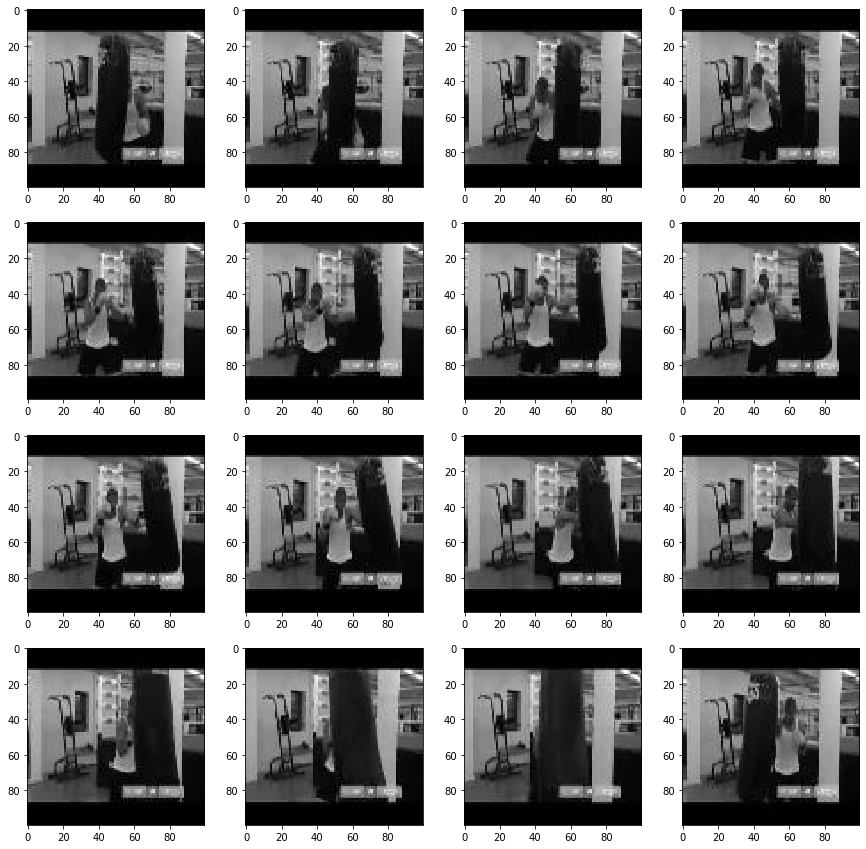

(1, 100, 100, 16)


In [54]:
tensorNr = 124

img_pack = datasetX[tensorNr]

#img_pack = datasetX.reshape(FRAME_SIZE,FRAME_SIZE,16) 
show_tensor(img_pack) 

prep_img_pack = prepDatasetX[tensorNr,:,:,:].reshape(1,FRAME_SIZE,FRAME_SIZE,16)
print(prep_img_pack.shape)



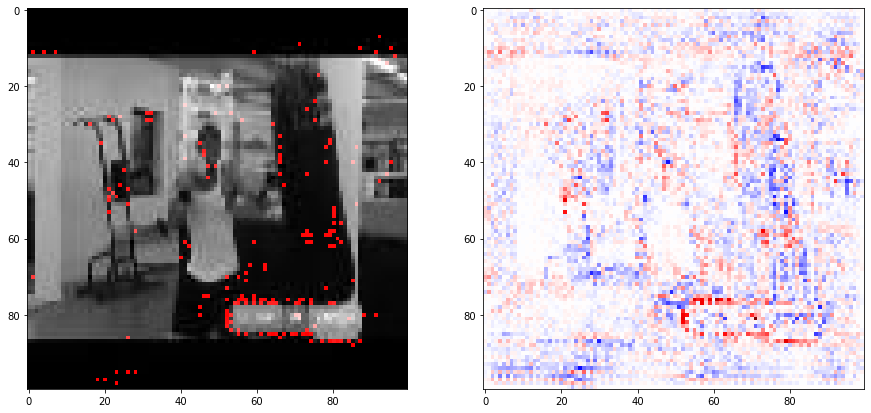

In [55]:

lrp_analyzer = innvestigate.analyzer.LRPZ(model_wo_sm)
#lrp_analyzer = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZ(model_wo_sm)

frameNr = 8
a = lrp_analyzer.analyze(prep_img_pack)
b = a.reshape(FRAME_SIZE,FRAME_SIZE,16)
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3)) 
#a /= np.max(np.abs(a))

p2 = get_img_from_tensor(b,frameNr)
p2 = p2.sum(axis=np.argmax(np.asarray(p2.shape) == 3))  
p2 /= np.max(np.abs(p2))
#print(p2)

# Plot
#plt.imshow(p2, cmap="seismic", clim=(-1, 1))
p3 = [p2 > 0.2]


plt.subplots(1,2,figsize=(15,15))
plt.subplot(1,2,2)
plt.imshow(p2, cmap="seismic", clim=(-1, 1))

i0 = get_img_from_tensor(img_pack,frameNr)
i0[:,:,0][p3] = 255

plt.subplot(1,2,1)
plt.imshow(i0)
plt.show()


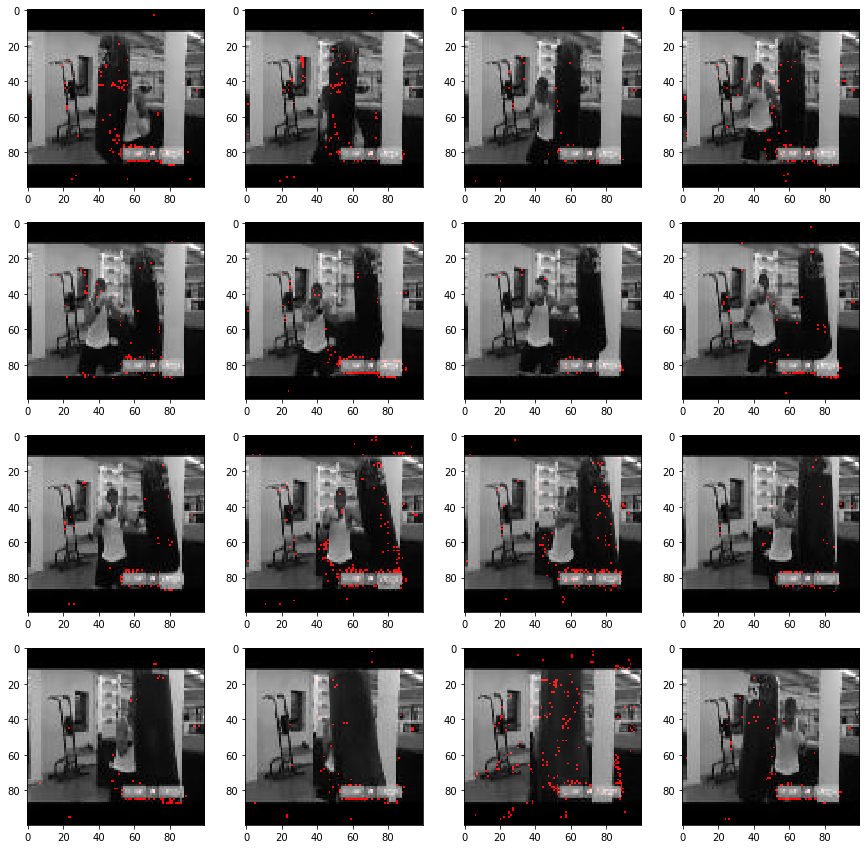

In [56]:
def set_hotspot_tensor(tensor, relevance):
    t = tensor
    for i in range(16):
        p = get_img_from_tensor(relevance,i)
        p = p.sum(axis=np.argmax(np.asarray(p.shape) == 3))
        p /= np.max(np.abs(p))
        t[:,:,i][p > 0.3] = 255
    return t  

lrp_analyzer = innvestigate.analyzer.LRPZ(model_wo_sm)
relevanceTensor = lrp_analyzer.analyze(prep_img_pack).reshape(FRAME_SIZE,FRAME_SIZE,16)
#hotspot_tensor = set_hotspot_tensor(img_pack, relevanceTensor)
#show_tensor(hotspot_tensor) 
show_hotspot(img_pack, relevanceTensor)

# TRASH

In [ ]:
modelx = innvestigate.utils.model_wo_softmax(model)

a = innvestigate.analyzer.relevance_based.relevance_analyzer.LRPZ(modelx)

# Create analyzer
analyzer = innvestigate.create_analyzer("deep_taylor", modelx)

# Add batch axis and preprocess
x = preprocess(img[None])
# Apply analyzer w.r.t. maximum activated output-neuron
a = analyzer.analyze(x)

# Aggregate along color channels and normalize to [-1, 1]
a = a.sum(axis=np.argmax(np.asarray(a.shape) == 3))
X /= 127.5    
# Plot
plt.imshow(a[0], cmap="seismic", clim=(-1, 1))

In [ ]:
analysis = innvestigate.analyzer.relevance_based.relevance_analyzer.LRP(x1, rule = "Z")
print(analysis.shape)

In [ ]:
a = analysis.reshape(FRAME_SIZE,FRAME_SIZE,16)
frm = 10
tensorList = [a[:,:,frm], a[:,:,frm], a[:,:,frm]]
img = np.stack(tensorList, axis=2)

plt.imshow(a.squeeze(), cmap='seismic', interpolation='nearest')
plt.show()

In [ ]:
inputData = read_file_to_list("F:/ud_MLEN/UU/CAIA_II/Project/wrk/prorun3/trainingFile")
(x,_) = create_dataset(inputData)
xData = x.astype("float32")
a, b = xData.min(), xData.max()
print(a,b)

In [ ]:
a, b = xData.min(), xData.max()
print(a,b)


In [ ]:
a, b = [0.0, 255.0]
c, d = [-1, 1]
print(a, b)
print(c, d)
print(d-c)

In [ ]:
        #X = X - a     ### X = X - 0.0
        # scale to new range gap [0, d-c]
        #X /= (b-a)    ### 255.0 - 0.0 => X/= 255.0
        #X *= (d-c)    ### X *= 2
        # shift to desired output range
        #X += c        ### X+= -1
        
        #X = X - c     ### X = X - (-1) = X + 1
        #X /= (d-c)    ### X /= 2
        #X *= (b-a)    ### X *= 255.0
        #X += a        ### X += 0.0

In [ ]:
image = data[2][7:8]

plot.imshow(image.squeeze(), cmap='gray', interpolation='nearest')
plot.show()

In [15]:
import numpy as np
a = np.asarray([[0.2, 0.3, 0.1, 0.0, 0.1],[0.1, 0.1, 0.0, 0.0, 0.1],[0.3, 0.1, 0.0, 0.2, 0.2]])
print(a[0], np.sum(a))

[0.2 0.3 0.1 0.  0.1] 1.8


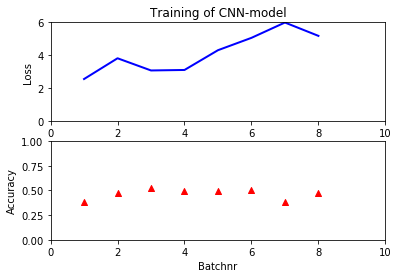

In [30]:
acc = [0.38, 0.47, 0.52, 0.49, 0.49, 0.50, 0.38, 0.47]
loss = [2.56, 3.82, 3.08, 3.11, 4.31, 5.06, 5.99, 5.18]

fig = plt.figure()
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
ax1.plot([1, 2, 3, 4, 5, 6, 7, 8], loss, color='blue', linewidth=2, label = "Loss")
ax2.scatter([1, 2, 3, 4, 5, 6, 7, 8], acc, color='red', marker='^', label = "Accuracy")
ax1.set_xlim(0, 10)
ax1.set_ylim(0, 6.0)
ax1.set(title="Training of CNN-model", xlabel="Batchnr", ylabel="Loss")
ax2.set_xlim(0, 10)
ax2.set_ylim(0, 1.0)
ax2.set(xlabel="Batchnr", ylabel="Accuracy")
plt.show()


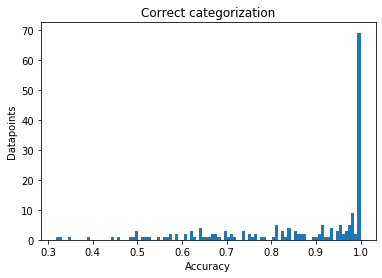

In [42]:
corr = [0.99990094, 0.9994887, 0.99998474, 0.9999341, 0.999985, 0.86929077, 0.7109086, 1.0, 1.0, 1.0, 1.0, 1.0, 0.85924494, 0.9010465, 0.5739567, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9999958, 0.99999607, 0.9999862, 0.5830565, 0.76715153, 0.90556693, 0.75439817, 0.9843105, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9959275, 0.9991109, 0.5568382, 0.9755661, 0.98952895, 0.99589217, 0.9913277, 0.9958811, 1.0, 1.0, 1.0, 1.0, 0.99999905, 0.999995, 0.999982, 0.9995265, 0.99956876, 0.9974004, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99956924, 0.99998975, 0.99981195, 0.96752685, 0.9932248, 0.99969697, 0.9999802, 0.99989784, 0.9999788, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99937505, 0.9100141, 0.9998098, 0.73618007, 0.999944, 1.0, 1.0, 1.0, 0.3720591, 1.0, 0.9999995, 0.99999475, 0.9999994, 0.9999982, 0.9999589, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9986835, 0.9999088, 0.9999392, 0.954046, 0.9997501, 0.952297, 0.5613758, 0.99999964, 0.99999857, 0.99999964, 1.0, 0.99999917, 0.9999999, 0.9999995, 1.0, 1.0, 0.94518846, 0.9972519, 0.9973055, 0.90532935, 0.8765253, 0.78689206, 0.78440374, 0.77373934, 0.7633322, 0.99740785, 0.99705935, 1.0, 1.0, 1.0, 1.0, 1.0, 0.84588224, 0.8384293, 0.8105275, 0.54767483, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99999154, 0.7089127, 0.81921023, 0.87628865, 0.8346782, 0.5591238, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.8147866, 1.0, 1.0, 1.0, 1.0, 1.0]
fail = [0.98079866, 0.7069891, 0.64544624, 0.8556495, 0.91239333, 0.9997842, 0.999864, 0.9996032, 0.9999944, 0.99984443, 0.39232498, 0.5626492, 0.6204214, 0.99999833, 0.9999989, 1.0, 0.9999391, 0.9997484, 0.9996474, 0.99954224, 0.82939106, 0.9991584, 0.9872125, 0.6692766, 0.9828774, 0.57605344, 0.99902534, 0.9988532, 0.99858356, 0.99624604, 0.9950504, 0.58713716, 0.8159803, 0.48234895, 0.6064306, 0.7832808, 0.5002475, 0.34613848, 0.31845027, 0.329104, 0.96105623, 0.81341726, 0.9899621, 0.6733469, 0.63966745, 0.8081677, 0.9933256, 0.6955323, 1.0, 0.99999976, 1.0, 0.999987, 0.99957854, 1.0, 0.8410408, 0.95447016, 0.6708266, 0.64450663, 0.99989426, 0.52082354, 0.6579489, 0.89707, 0.84240794, 0.6950367, 0.81426275, 0.99999785, 0.99867, 0.93526983, 0.94872785, 0.99853396, 0.99997056, 0.99996173, 0.99997187, 0.9999529, 0.99975306, 0.99962246, 0.999757, 1.0, 0.9992393, 0.9246042, 0.9999212, 0.7368482, 0.7362475, 0.7060488, 0.68540984, 0.6183723, 0.91256094, 0.9556354, 0.9979184, 1.0, 1.0, 1.0, 0.9983714, 0.9993807, 0.9997359, 0.96810883, 0.99630934, 0.9178787, 0.93408716, 0.9580926, 0.977405, 0.98229516, 0.87708855, 0.9756237, 0.972201, 0.99888676, 0.5487707, 0.51488495, 0.45616734, 0.94654197, 0.9853495, 0.93297315, 0.9370222, 0.8152746, 0.82714105, 0.9652967, 0.77592576, 0.9990332, 0.99432254, 0.9825342, 0.96910167, 0.985713, 0.8610083, 0.7381719, 0.56955886, 0.8557799, 0.98108196, 0.707368, 0.8759972, 0.6474037, 0.8319587, 0.6214918, 0.86037534, 0.99489427, 0.99985397, 0.9999999, 0.6737617, 0.99995935, 0.9999863, 0.9999788, 0.99690956, 0.52327967, 0.9104314, 0.749607, 0.44149485, 0.5018435, 0.76367223, 0.71411026, 0.5004783, 0.9996798, 0.6276586, 0.64261293, 0.9999963, 0.9848444, 1.0, 0.6628938, 0.92962265, 0.90308195, 0.8692106, 0.7482414, 0.83671176, 0.8149969, 0.91614383, 0.8667724, 0.8507798, 0.57065636, 0.9792625, 0.99406505, 0.997422, 0.9969612, 0.99585813, 0.9973405, 0.9065678, 0.49479395, 0.9728095, 0.59105897, 0.95461875, 0.8371651, 0.99762326, 0.60867685, 0.9584255, 0.6969223, 0.7641299, 0.82829267, 0.9986702, 0.9996643, 0.94861895, 0.9993181, 0.75778794, 0.91500765, 0.9837255, 0.973281]


plt.hist(fail, bins=100)
plt.title("Correct categorization")
plt.xlabel("Accuracy")
plt.ylabel("Datapoints")
plt.show()